In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random
from decimal import Decimal

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib as mpl

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import models_pruning
import loss
import metrics
import train_epoch
import val_epoch
import utils

# AIMET imports

In [2]:
from aimet_torch.compress import ModelCompressor
from aimet_torch.defs import SpatialSvdParameters
from aimet_torch.onnx_utils import OnnxSaver
from aimet_common.defs import CostMetric, CompressionScheme, GreedySelectionParameters
# from aimet_common.utils import start_bokeh_server_session
# from aimet_torch.visualize_serialized_data import VisualizeCompression

2024-07-03 17:18:50,355 - root - INFO - AIMET


# Supress Warnings

In [3]:
# import warnings
# warnings.filterwarnings('ignore')

# Empty Cuda

In [4]:
#torch.cuda.empty_cache()

# Define Matplot Style

In [5]:
mpl.style.use('seaborn-v0_8')

# Logger

In [6]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tAdding best mean F1 save.\n' +
            '\t256 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            f'\tSVD Compression Ratio  = {config.SVD_COMPRESSION_RATIO}\n' +
            f'\t{config.EPOCHS} epochs.\n')

# View Dataset

### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

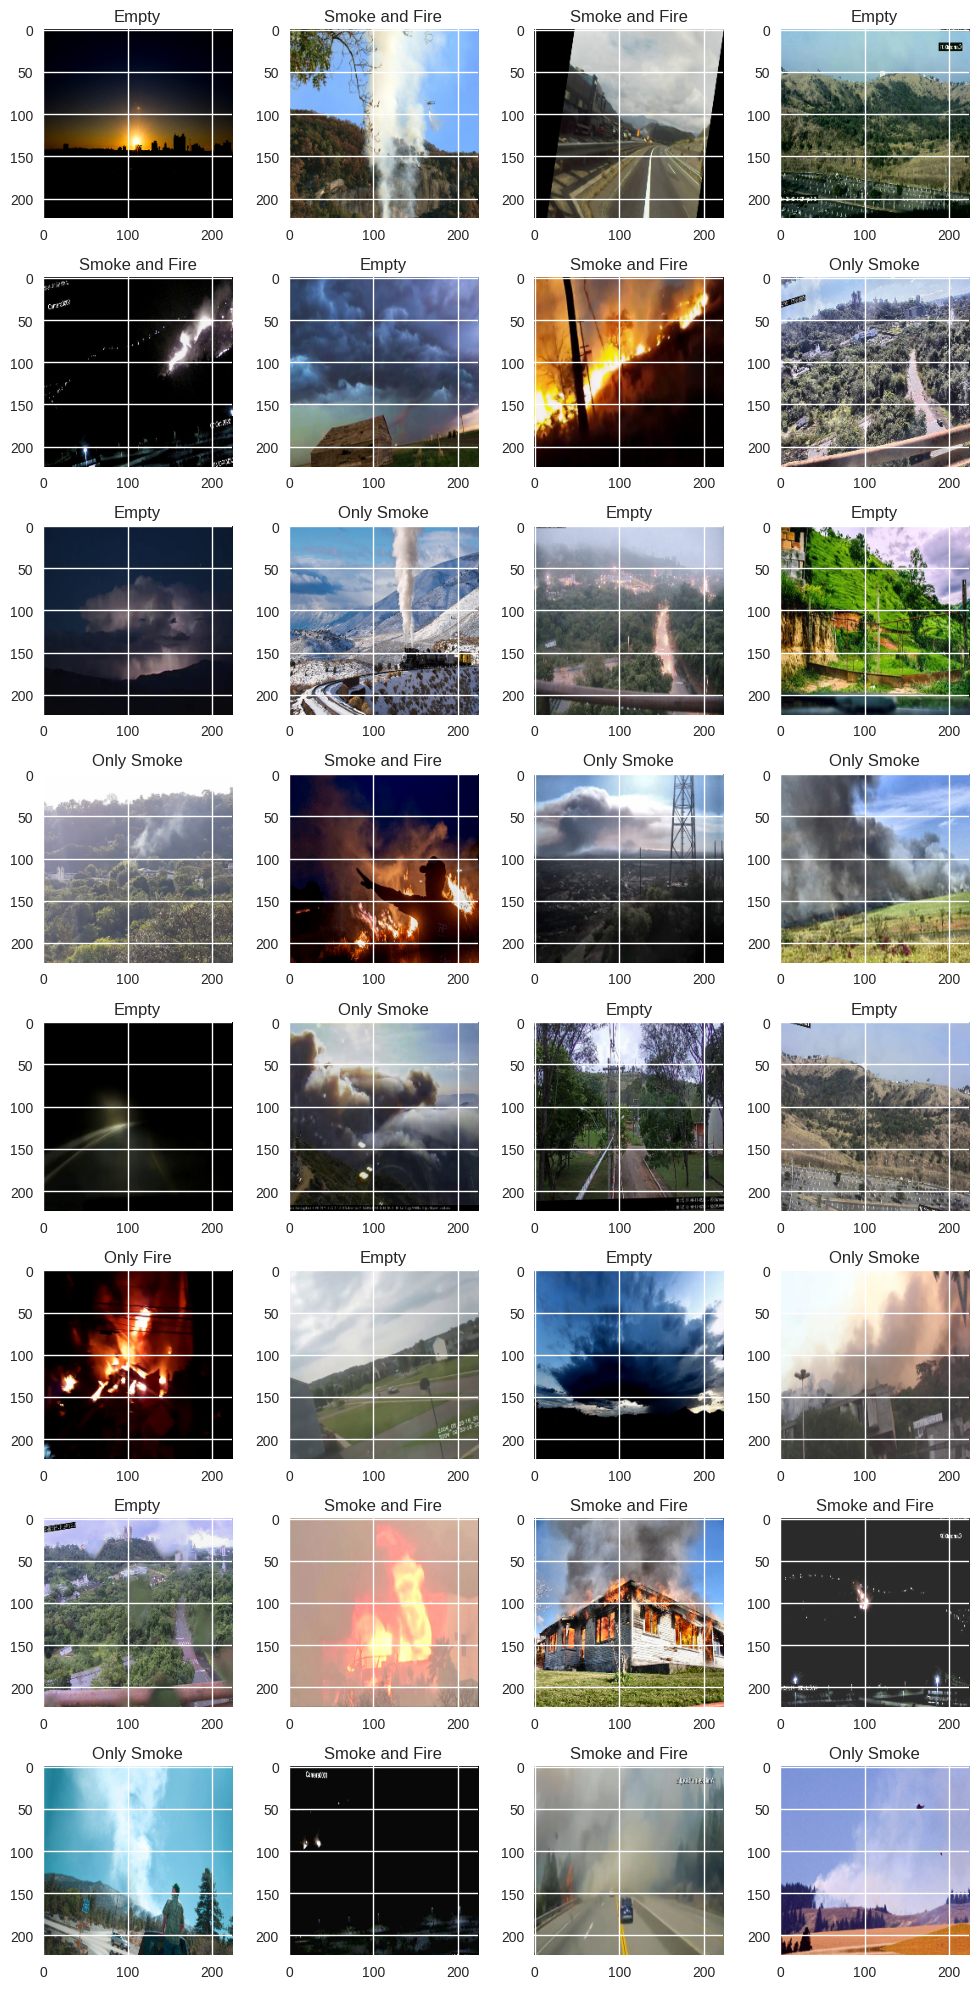

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [10]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Models Setup

In [11]:
if config.MODEL == "BED":   
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models_pruning.PRUNED_BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in fp32_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(fp32_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 80830
Total parameters = 80830



### Check Model Shape

In [12]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = fp32_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{fp32_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{fp32_model}')

Model shape is tensor([[0.1441, 0.2068],
        [0.1461, 0.2052],
        [0.1447, 0.2090],
        [0.1416, 0.2078]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
PRUNED_BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(28, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(12, 8, kernel_size=(1, 1), stride=(1, 1))
    (relu31): ReLU()
    (conv32): Conv2d(8, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu32): ReLU()
    (conv33): Conv2d(22, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu33): ReLU()
    (conv34): Conv2d(32,

# Load Pretrained or Initialize Weights

In [13]:
epochs_trained = utils.load_checkpoint(config.LOAD_MODEL_FILE, 
                                       fp32_model, 
                                       optimizer=None, 
                                       scheduler=None, 
                                       device=config.DEVICE)

logger.info(f"Loading Model. Trained during {epochs_trained} epochs")

Loading Model. Trained during 9 epochs


# Torchinfo: model summary

In [14]:
print(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info("Original FP32 Model Summary")
logger.info(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
PRUNED_BED_CLASSIFIER                    [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 28, 224, 224]        784
│    └─ReLU: 2-2                         [64, 28, 224, 224]        --
│    └─Dropout2d: 2-3                    [64, 28, 224, 224]        --
│    └─MaxPool2d: 2-4                    [64, 28, 112, 112]        --
│    └─Conv2d: 2-5                       [64, 12, 112, 112]        3,036
│    └─ReLU: 2-6                         [64, 12, 112, 112]        --
│    └─Dropout2d: 2-7                    [64, 12, 112, 112]        --
│    └─MaxPool2d: 2-8                    [64, 12, 56, 56]          --
│    └─Conv2d: 2-9                       [64, 8, 56, 56]           104
│    └─ReLU: 2-10                        [64, 8, 56, 56]           --
│    └─Conv2d: 2-11                      [64, 22, 56, 56]          1,606
│    └─

# Save ONNX original model

In [15]:
input_shape = (1, 3, config.IMG_H, config.IMG_W)

torch.onnx.export(fp32_model, torch.randn(input_shape).to(config.DEVICE), config.RUN_FOLDER + 'fp32_model_pruned.onnx')
#OnnxSaver.set_node_names('/models/fp32_model.onnx', fp32_model, input_shape)

# AIMET Spatial SVD

### Start Visualization Server

In [16]:
# visualization_url, process = start_bokeh_server_session()
# print(visualization_url)

### Configure SVD Parameters

In [17]:
modules_to_ignore = []

greedy_params = GreedySelectionParameters(
    target_comp_ratio=Decimal(config.SVD_COMPRESSION_RATIO), 
    saved_eval_scores_dict=config.SVD_DIC_FILE)

auto_params = SpatialSvdParameters.AutoModeParams(
    greedy_params,
    modules_to_ignore=modules_to_ignore)

spatial_svd_params = SpatialSvdParameters(
    mode=SpatialSvdParameters.Mode.auto,
    params=auto_params)

### Evaluate Model Callback

Signature: (model, iterations, use_cuda)
Return an accuracy metric

In [18]:
def evaluate_model(model, iterations, use_cuda):
    
    model.eval()

    for batch_idx, (x, y) in enumerate(val_loader):
        if use_cuda == True:
            x, y = x.to('cuda'), y.to('cuda')
        else:
            model.to('cpu')
        out = model(x)
        if iterations is not None:
            if batch_idx == iterations:
                break
        
        # F1 average Macro   
        yhat = torch.sigmoid(out.detach())
        metrics.f1_metric_mean.update(yhat, y)
    
    f1_mean = metrics.f1_metric_mean.compute()
    metrics.f1_metric_mean.reset()

    print(f'F1 mean: {f1_mean:.4f}')
    
    return f1_mean.item()

### Baseline F1 Mean

In [19]:
baseline_f1 = evaluate_model(fp32_model, None, True)
print(type(baseline_f1))

F1 mean: 0.9170
<class 'float'>


In [20]:
comp_model, stats = ModelCompressor.compress_model(fp32_model,
                                                   input_shape=input_shape,
                                                   eval_callback=evaluate_model,
                                                   eval_iterations=None,
                                                   compress_scheme=CompressionScheme.spatial_svd,
                                                   cost_metric=CostMetric.mac,
                                                   parameters=spatial_svd_params,
                                                   visualization_url=None)                                                          

2024-07-03 17:20:23,901 - CompRatioSelect - INFO - Greedy selection: Read eval dict from ./data/greedy_selection_eval_scores_dict.pkl
2024-07-03 17:20:23,901 - CompRatioSelect - INFO - Greedy selection: overall_min_score=0.000000, overall_max_score=0.918422
2024-07-03 17:20:23,902 - CompRatioSelect - INFO - Greedy selection: Original model cost=(Cost: memory=80372, mac=179304992)
2024-07-03 17:20:23,906 - CompRatioSelect - INFO - Greedy selection: final choice - comp_ratio=0.766980, score=0.916684
2024-07-03 17:20:23,908 - Svd - INFO - Spatial SVD splitting layer: model.conv2 using rank: 12
2024-07-03 17:20:23,909 - Svd - INFO - Spatial SVD splitting layer: model.conv31 using rank: 4
2024-07-03 17:20:23,909 - Svd - INFO - Spatial SVD splitting layer: model.conv34 using rank: 49
2024-07-03 17:20:23,916 - Svd - INFO - Spatial SVD splitting layer: model.conv44 using rank: 44
2024-07-03 17:20:23,920 - Svd - INFO - Spatial SVD splitting layer: model.conv46 using rank: 21
F1 mean: 0.9170
F1 

In [21]:
print(comp_model)
logger.info(comp_model)

PRUNED_BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Sequential(
      (0): Conv2d(28, 12, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (1): Conv2d(12, 12, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Sequential(
      (0): Conv2d(12, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (relu31): ReLU()
    (conv32): Conv2d(8, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu32): ReLU()
    (conv33): Conv2d(22, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu33):

### Print Stats

In [22]:
print(stats)
logger.info(stats)

**********************************************************************************************
Compressed Model Statistics
Baseline model accuracy: 0.916980, Compressed model accuracy: 0.918279
Compression ratio for memory=0.757552, mac=0.766980

**********************************************************************************************

Per-layer Stats
    Name:model.conv1, compression-ratio: None
    Name:model.conv2, compression-ratio: 0.5
    Name:model.conv31, compression-ratio: 0.9
    Name:model.conv32, compression-ratio: None
    Name:model.conv33, compression-ratio: None
    Name:model.conv34, compression-ratio: 0.8
    Name:model.conv41, compression-ratio: None
    Name:model.conv42, compression-ratio: None
    Name:model.conv43, compression-ratio: None
    Name:model.conv44, compression-ratio: 0.7
    Name:model.conv45, compression-ratio: None
    Name:model.conv46, compression-ratio: 0.4

***********************************************************************************

### Torchinfo: model compressed summary

In [23]:
print(summary(comp_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info("Compressed Model Summary")
logger.info(summary(comp_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
PRUNED_BED_CLASSIFIER                    [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 28, 224, 224]        784
│    └─ReLU: 2-2                         [64, 28, 224, 224]        --
│    └─Dropout2d: 2-3                    [64, 28, 224, 224]        --
│    └─MaxPool2d: 2-4                    [64, 28, 112, 112]        --
│    └─Sequential: 2-5                   [64, 12, 112, 112]        --
│    │    └─Conv2d: 3-1                  [64, 12, 112, 112]        1,008
│    │    └─Conv2d: 3-2                  [64, 12, 112, 112]        444
│    └─ReLU: 2-6                         [64, 12, 112, 112]        --
│    └─Dropout2d: 2-7                    [64, 12, 112, 112]        --
│    └─MaxPool2d: 2-8                    [64, 12, 56, 56]          --
│    └─Sequential: 2-9                   [64, 8, 56, 56]           --
│    │    

### Evaluate Compressed Model

In [24]:
comp_f1 = evaluate_model(comp_model, None, True)

F1 mean: 0.9183


### Visualize Results

In [25]:
comp_ratios_file_path = './data/greedy_selection_comp_ratios_list.pkl'
eval_scores_path = './data/greedy_selection_eval_scores_dict.pkl'

unpickled_ratios = pd.read_pickle(comp_ratios_file_path)
unpickled_scores = pd.read_pickle(eval_scores_path)

In [26]:
df_scores = pd.DataFrame(unpickled_scores)
df_scores.to_csv(config.RUN_FOLDER + 'scores.csv')
print(df_scores)

     model.conv1  model.conv2  model.conv31  model.conv32  model.conv33  \
0.1     0.522551     0.901380      0.672896      0.312198      0.000000   
0.2     0.522551     0.911370      0.672896      0.405101      0.144275   
0.3     0.641317     0.915321      0.672896      0.829487      0.129477   
0.4     0.721748     0.914946      0.672896      0.871845      0.619261   
0.5     0.766223     0.917391      0.887041      0.892696      0.702697   
0.6     0.766223     0.917289      0.887041      0.899804      0.800568   
0.7     0.815632     0.917296      0.914199      0.910515      0.893814   
0.8     0.881330     0.916702      0.914199      0.912603      0.902945   
0.9     0.916062     0.916783      0.918209      0.914377      0.902821   

     model.conv34  model.conv41  model.conv42  model.conv43  model.conv44  \
0.1      0.379709      0.311521      0.697456      0.576745      0.361145   
0.2      0.787633      0.273121      0.789834      0.545149      0.470135   
0.3      0.891317 

In [27]:
df_ratios = pd.DataFrame(unpickled_ratios)
df_ratios.to_csv(config.RUN_FOLDER + 'ratios.csv')
print(df_ratios)

               0     1
0    model.conv1  None
1    model.conv2   0.5
2   model.conv31   0.9
3   model.conv32  None
4   model.conv33  None
5   model.conv34   0.8
6   model.conv41  None
7   model.conv42  None
8   model.conv43  None
9   model.conv44   0.7
10  model.conv45  None
11  model.conv46   0.4


# Save Compressed Before Training

In [28]:
torch.onnx.export(comp_model, torch.randn(input_shape).to(config.DEVICE), config.RUN_FOLDER + 'comp_model_noTrain.onnx')

### Optimizer and Scheduler of Compressed Model to Train

In [29]:
optimizer = optim.Adam(comp_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

utils.save_checkpoint(epoch=0, 
                      model=comp_model,
                      optimizer=optimizer,
                      scheduler=scheduler,
                      checkpoint_name=config.WEIGHTS_FOLDER + 'comp_model_after_svd.pt')

# Loss Function

In [30]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [31]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [32]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Train Loop Function

In [33]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 

        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Training

In [34]:
print("Start Training\n")
logger.info("Start Training\n")

trained_model = train_loop(comp_model)

Start Training


***Start Training: 17:20:35


=== EPOCH 0/19 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.699      |18.138      |8.561       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.653      |14.795      |6.858       
SMOKE -> Precision: 0.874 - Recall: 0.931 - Accuracy: 0.903 - F1: 0.902
FIRE -> Precision: 0.941 - Recall: 0.918 - Accuracy: 0.964 - F1: 0.929

Saving model with new best validation loss: 21.653

Saving model with new best smoke precision: 0.874
Saving model with best Mean F1: 0.9156

=== EPOCH 1/19 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.304      |17.775      |8.529       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.298      |15.317      |6.981       
SMOKE -> Precision: 0.929 - Recall: 0.849 - Accuracy: 0.896 - F1: 0.887
FIRE -> Precision: 0.931 - Recall: 0.931 - Accuracy: 0.964 - F1: 0.931

=== EPOCH 2/19 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 12.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.335      |17.822      |8.512       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.216      |14.271      |6.945       
SMOKE -> Precision: 0.883 - Recall: 0.927 - Accuracy: 0.906 - F1: 0.904
FIRE -> Precision: 0.921 - Recall: 0.926 - Accuracy: 0.960 - F1: 0.924

Saving model with new best validation loss: 21.216

Saving model with new best smoke precision: 0.883

=== EPOCH 3/19 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.729      |17.949      |8.780       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.282      |14.053      |7.229       
SMOKE -> Precision: 0.908 - Recall: 0.893 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.901 - Recall: 0.946 - Accuracy: 0.959 - F1: 0.923

Saving model with new best smoke precision: 0.908

=== EPOCH 4/19 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.918      |17.548      |8.370       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 18.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.071      |13.808      |7.262       
SMOKE -> Precision: 0.906 - Recall: 0.903 - Accuracy: 0.908 - F1: 0.905
FIRE -> Precision: 0.908 - Recall: 0.938 - Accuracy: 0.959 - F1: 0.923

Saving model with new best validation loss: 21.071

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 5/19 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.470      |17.813      |8.657       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.429      |14.017      |7.411       
SMOKE -> Precision: 0.898 - Recall: 0.910 - Accuracy: 0.907 - F1: 0.904
FIRE -> Precision: 0.891 - Recall: 0.949 - Accuracy: 0.957 - F1: 0.919

=== EPOCH 6/19 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.046      |17.818      |8.228       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.575      |14.402      |7.173       
SMOKE -> Precision: 0.881 - Recall: 0.924 - Accuracy: 0.903 - F1: 0.902
FIRE -> Precision: 0.904 - Recall: 0.943 - Accuracy: 0.959 - F1: 0.923

=== EPOCH 7/19 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.528      |17.320      |8.208       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.115      |13.871      |7.243       
SMOKE -> Precision: 0.912 - Recall: 0.891 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.906 - Recall: 0.944 - Accuracy: 0.960 - F1: 0.925

Saving model with new best smoke precision: 0.912

=== EPOCH 8/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.777      |17.605      |8.172       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.826      |13.946      |6.880       
SMOKE -> Precision: 0.901 - Recall: 0.906 - Accuracy: 0.907 - F1: 0.904
FIRE -> Precision: 0.930 - Recall: 0.930 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 20.826

Saving model with precision > 0.9 and recall > 0.9
Saving model with best Mean F1: 0.9167

=== EPOCH 9/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.081      |17.485      |8.597       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.811      |13.850      |6.961       
SMOKE -> Precision: 0.897 - Recall: 0.918 - Accuracy: 0.910 - F1: 0.907
FIRE -> Precision: 0.927 - Recall: 0.935 - Accuracy: 0.964 - F1: 0.931

Saving model with new best validation loss: 20.811
Saving model with best Mean F1: 0.9191

=== EPOCH 10/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.120      |17.158      |7.961       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 18.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.908      |13.959      |6.948       
SMOKE -> Precision: 0.896 - Recall: 0.923 - Accuracy: 0.911 - F1: 0.909
FIRE -> Precision: 0.931 - Recall: 0.937 - Accuracy: 0.966 - F1: 0.934
Saving model with best Mean F1: 0.9215

=== EPOCH 11/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.480      |17.405      |8.075       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 18.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.895      |14.026      |6.869       
SMOKE -> Precision: 0.909 - Recall: 0.896 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.941 - Recall: 0.920 - Accuracy: 0.964 - F1: 0.930

=== EPOCH 12/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.700      |17.460      |8.240       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.780      |13.880      |6.900       
SMOKE -> Precision: 0.906 - Recall: 0.901 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.913 - Recall: 0.932 - Accuracy: 0.959 - F1: 0.922

Saving model with new best validation loss: 20.780

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 13/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.243      |17.204      |8.039       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 18.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.201      |14.549      |6.651       
SMOKE -> Precision: 0.925 - Recall: 0.857 - Accuracy: 0.898 - F1: 0.890
FIRE -> Precision: 0.938 - Recall: 0.928 - Accuracy: 0.965 - F1: 0.933

=== EPOCH 14/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 12.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.210      |17.093      |8.116       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 18.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.798      |13.936      |6.862       
SMOKE -> Precision: 0.912 - Recall: 0.891 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.935 - Recall: 0.927 - Accuracy: 0.964 - F1: 0.931

=== EPOCH 15/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.586      |17.217      |8.369       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 18.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.577      |13.823      |6.754       
SMOKE -> Precision: 0.901 - Recall: 0.907 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.925 - Recall: 0.933 - Accuracy: 0.963 - F1: 0.929

Saving model with new best validation loss: 20.577

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 16/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.905      |16.901      |8.004       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 18.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.352      |14.237      |7.115       
SMOKE -> Precision: 0.900 - Recall: 0.905 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.909 - Recall: 0.937 - Accuracy: 0.959 - F1: 0.923

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 17/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.583      |16.742      |7.840       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 18.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.617      |13.893      |6.723       
SMOKE -> Precision: 0.916 - Recall: 0.888 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.919 - Recall: 0.933 - Accuracy: 0.962 - F1: 0.926

Saving model with new best smoke precision: 0.916

=== EPOCH 18/19 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.055      |17.091      |7.963       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 18.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.258      |14.331      |6.927       
SMOKE -> Precision: 0.884 - Recall: 0.924 - Accuracy: 0.905 - F1: 0.904
FIRE -> Precision: 0.915 - Recall: 0.937 - Accuracy: 0.961 - F1: 0.926

=== EPOCH 19/19 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.797      |16.812      |7.985       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 18.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.123      |13.792      |7.331       
SMOKE -> Precision: 0.916 - Recall: 0.896 - Accuracy: 0.911 - F1: 0.906
FIRE -> Precision: 0.892 - Recall: 0.949 - Accuracy: 0.957 - F1: 0.920

***Script finished: 17:29:36

Time elapsed: 0:09:00.600268


# Check Comp Model Params

In [35]:
# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in comp_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = sum(p.numel() for p in comp_model.parameters())
print(f'Total parameters = {n_params}')
logger.info(f'Total parameters = {n_params}\n')


Trainable parameters = 61344
Total parameters = 61344


# Export to ONNX

In [36]:
torch.onnx.export(trained_model, torch.randn(input_shape).to(config.DEVICE), config.RUN_FOLDER + 'comp_model_Train.onnx')
#OnnxSaver.set_node_names('/models/fp32_model.onnx', trained_model, input_shape)